In [3]:
%matplotlib inline
import requests
from bs4 import BeautifulSoup
import os
import pandas as pd
import time
import re
import seaborn as sns
from lxml import html
import matplotlib.pyplot as plt
from collections import Counter

%config InlineBackend.figure_format = 'svg'
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

Получаем 250 самых топовых фильмов

In [4]:
url = 'http://www.imdb.com/chart/top'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'lxml')

In [3]:
soup

<!DOCTYPE html>
<html xmlns:fb="http://www.facebook.com/2008/fbml" xmlns:og="http://ogp.me/ns#">
<head>
<meta charset="utf-8"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible"/>
<script type="text/javascript">var IMDbTimer={starttime: new Date().getTime(),pt:'java'};</script>
<script>
    if (typeof uet == 'function') {
      uet("bb", "LoadTitle", {wb: 1});
    }
</script>
<script>(function(t){ (t.events = t.events || {})["csm_head_pre_title"] = new Date().getTime(); })(IMDbTimer);</script>
<title>Top 250 Movies - IMDb</title>
<script>(function(t){ (t.events = t.events || {})["csm_head_post_title"] = new Date().getTime(); })(IMDbTimer);</script>
<script>
    if (typeof uet == 'function') {
      uet("be", "LoadTitle", {wb: 1});
    }
</script>
<script>
    if (typeof uex == 'function') {
      uex("ld", "LoadTitle", {wb: 1});
    }
</script>
<link href="https://www.imdb.com/chart/top" rel="canonical"/>
<meta content="http://www.imdb.com/chart/top" property="og:url"/>
<script>
   

Парсим страницу с фильмами и получаем грязные данные с


1.   Названием фильма
2.   Рейтингом
3.   Командой 
4.   Ссылкой на основную страницу




In [5]:
movies = soup.select('td.titleColumn')
links = [a.attrs.get('href') for a in soup.select('td.titleColumn a')]
crew = [a.attrs.get('title') for a in soup.select('td.titleColumn a')]
ratings = [b.attrs.get('data-value') for b in soup.select('td.posterColumn span[name=ir]')]

In [6]:
data_frame = {
    "movies": movies,
    "ratings": ratings,
    "crew": crew,
    "links": links
}

data = pd.DataFrame(data_frame)
data.head

<bound method NDFrame.head of                                                 movies            ratings  \
0    [\n      1.\n      , [Побег из Шоушенка], \n, ...  9.240018721792582   
1    [\n      2.\n      , [Крёстный отец], \n, [(19...  9.161081071409665   
2    [\n      3.\n      , [Темный рыцарь], \n, [(20...  8.994029974295776   
3    [\n      4.\n      , [Крёстный отец 2], \n, [(...  8.990209207003002   
4    [\n      5.\n      , [12 рaзгневанных мужчин],...  8.950843076478664   
..                                                 ...                ...   
245  [\n      246.\n      , [Красавица и чудовище],...  8.016639644020154   
246  [\n      247.\n      , [Ганди], \n, [(1982)], \n]  8.015129720909291   
247  [\n      248.\n      , [Прислуга], \n, [(2011)...   8.01445498535191   
248  [\n      249.\n      , [Служанка], \n, [(2016)...  8.012905661012905   
249  [\n      250.\n      , [Да прольётся свет], \n...  8.008741900393186   

                                             

Несколько функциий для преобразования грязных заголовков с названием фильмов


In [7]:
def process_text_mv(text):
    data = text.get_text().split("\n")
    return data[2].strip()

In [8]:
def process_text_year(text):
    data = text.get_text().split("\n")
    return data[3].strip()[1:-1]

In [9]:
data["title"] = data.movies.apply(process_text_mv)
data["year"] = data.movies.apply(process_text_year)

In [10]:
data.head()

,movies,ratings,crew,links,title,year
0,"[\n 1.\n , [Побег из Шоушенка], \n, ...",9.240018721792582,"Frank Darabont (dir.), Tim Robbins, Morgan Fre...",/title/tt0111161/,Побег из Шоушенка,1994
1,"[\n 2.\n , [Крёстный отец], \n, [(19...",9.161081071409665,"Francis Ford Coppola (dir.), Marlon Brando, Al...",/title/tt0068646/,Крёстный отец,1972
2,"[\n 3.\n , [Темный рыцарь], \n, [(20...",8.994029974295776,"Christopher Nolan (dir.), Christian Bale, Heat...",/title/tt0468569/,Темный рыцарь,2008
3,"[\n 4.\n , [Крёстный отец 2], \n, [(...",8.990209207003002,"Francis Ford Coppola (dir.), Al Pacino, Robert...",/title/tt0071562/,Крёстный отец 2,1974
4,"[\n 5.\n , [12 рaзгневанных мужчин],...",8.950843076478664,"Sidney Lumet (dir.), Henry Fonda, Lee J. Cobb",/title/tt0050083/,12 рaзгневанных мужчин,1957


In [11]:
data.crew[1]

'Francis Ford Coppola (dir.), Marlon Brando, Al Pacino'

In [22]:
#task_1. Получить список всех участников команд (убрать постфикс `(dir.)` у директоров). Найти количество уникальных имен.

#deleting (dir.)
crew_no_dir = data["crew"].str.replace(" \(dir.\)", "", regex=True)

#list with crews
crew_list = crew_no_dir.tolist()

#list of all members of crews
crew_list_split = ", ".join(crew_list).split(", ")

unique_crew_list = set(crew_list_split)

In [23]:
print(f"Number of unique names: {len(unique_crew_list)}")

Number of unique names: 527


In [24]:
#task_2. Получить список всех директоров. Построить распределение (визуализация обязательна) и найти директора(ов), у которого(ых) больше всего фильмов в топе.

#list with crews and (dir.)s
crew_list_with_dir = data["crew"].tolist()

In [64]:
#searching for directors in list with crews and dirs
#creating a dict with dirs and number of films they directed
all_dirs = {}

for i in crew_list_with_dir:
    for name in i.split(", "):
        if name.endswith(" (dir.)"):
            if name in all_dirs:
                all_dirs[name] += 1
            else:
                all_dirs[name] = 1

In [65]:
#splitting dict into separate lists
directors, num = zip(*all_dirs.items())
#deleting (dir.) from names
dirs_names = []

for s in directors:
    for name in s.replace(" (dir.)", "").split(", "):
        dirs_names.append(name)
#list of all directors
dirs_names

['Frank Darabont',
 'Francis Ford Coppola',
 'Christopher Nolan',
 'Sidney Lumet',
 'Steven Spielberg',
 'Peter Jackson',
 'Quentin Tarantino',
 'Sergio Leone',
 'Robert Zemeckis',
 'David Fincher',
 'Irvin Kershner',
 'Lana Wachowski',
 'Martin Scorsese',
 'Milos Forman',
 'Akira Kurosawa',
 'Frank Capra',
 'Jonathan Demme',
 'Fernando Meirelles',
 'Roberto Benigni',
 'George Lucas',
 'James Cameron',
 'Hayao Miyazaki',
 'Alfred Hitchcock',
 'Luc Besson',
 'Roman Polanski',
 'Bong Joon Ho',
 'Roger Allers',
 'Ridley Scott',
 'Tony Kaye',
 'Bryan Singer',
 'Michael Curtiz',
 'Damien Chazelle',
 'Olivier Nakache',
 'Charles Chaplin',
 'Masaki Kobayashi',
 'Isao Takahata',
 'Giuseppe Tornatore',
 'Andrew Stanton',
 'Florian Henckel von Donnersmarck',
 'Billy Wilder',
 'Stanley Kubrick',
 'Anthony Russo',
 'Sam Mendes',
 'Jon Watts',
 'Todd Phillips',
 'Bob Persichetti',
 'Park Chan-wook',
 'Mel Gibson',
 'John Lasseter',
 'Lee Unkrich',
 'Wolfgang Petersen',
 'Gus Van Sant',
 'Darren Aro

In [74]:
#finding top-10 dirs
df_dirs_nums = pd.DataFrame(all_dirs.items(), columns=['dirs', 'num_of_films']).nlargest(10, "num_of_films")

In [75]:
df_dirs_nums

,dirs,num_of_films
2,Christopher Nolan (dir.),7
4,Steven Spielberg (dir.),7
12,Martin Scorsese (dir.),7
14,Akira Kurosawa (dir.),7
40,Stanley Kubrick (dir.),7
22,Alfred Hitchcock (dir.),6
6,Quentin Tarantino (dir.),5
33,Charles Chaplin (dir.),5
39,Billy Wilder (dir.),5
7,Sergio Leone (dir.),4


<AxesSubplot:xlabel='dirs', ylabel='num_of_films'>

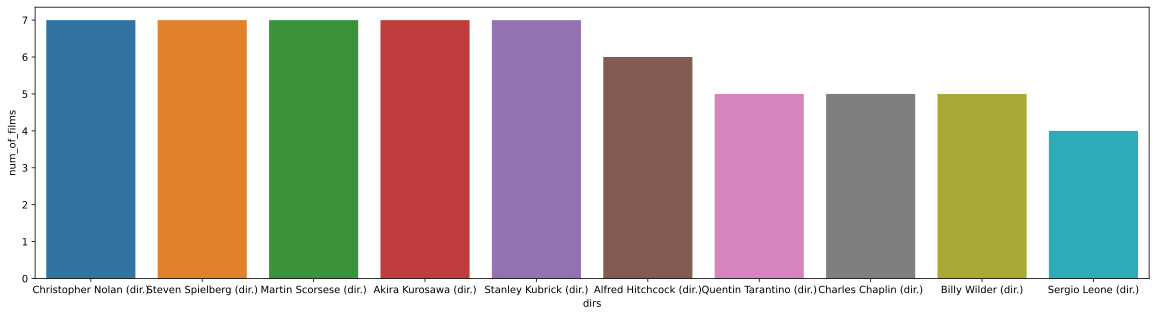

In [78]:
f, ax = plt.subplots(figsize=(20, 5))

sns.barplot(data = df_dirs_nums, x = "dirs", y = "num_of_films")

In [ ]:
#task_3. Найти участника(ов) команд, у которого(ых) больше всего фильмов в топе.

In [81]:
#creating a dict with actors and number of films they took part in
all_actors = {}

for i in crew_list_with_dir:
    for name in i.split(", "):
        if not name.endswith(" (dir.)"):
            if name in all_actors:
                all_actors[name] += 1
            else:
                all_actors[name] = 1

In [82]:
all_actors

{'Tim Robbins': 1,
 'Morgan Freeman': 2,
 'Marlon Brando': 3,
 'Al Pacino': 4,
 'Christian Bale': 5,
 'Heath Ledger': 1,
 'Robert De Niro': 9,
 'Henry Fonda': 3,
 'Lee J. Cobb': 1,
 'Liam Neeson': 1,
 'Ralph Fiennes': 2,
 'Elijah Wood': 3,
 'Viggo Mortensen': 2,
 'John Travolta': 1,
 'Uma Thurman': 2,
 'Ian McKellen': 2,
 'Clint Eastwood': 5,
 'Eli Wallach': 1,
 'Tom Hanks': 6,
 'Robin Wright': 1,
 'Brad Pitt': 4,
 'Edward Norton': 2,
 'Leonardo DiCaprio': 5,
 'Joseph Gordon-Levitt': 1,
 'Mark Hamill': 3,
 'Harrison Ford': 6,
 'Keanu Reeves': 1,
 'Laurence Fishburne': 1,
 'Ray Liotta': 1,
 'Jack Nicholson': 3,
 'Louise Fletcher': 1,
 'Toshirô Mifune': 4,
 'Takashi Shimura': 2,
 'James Stewart': 4,
 'Donna Reed': 1,
 'Jodie Foster': 2,
 'Anthony Hopkins': 3,
 'Matt Damon': 4,
 'Alexandre Rodrigues': 1,
 'Leandro Firmino': 1,
 'Roberto Benigni': 1,
 'Nicoletta Braschi': 1,
 'Michael Clarke Duncan': 1,
 'Matthew McConaughey': 1,
 'Anne Hathaway': 1,
 'Arnold Schwarzenegger': 2,
 'Linda Ha

In [83]:
#finding top-10 actors
df_acts_nums = pd.DataFrame(all_actors.items(), columns=['actors', 'num_of_films']).nlargest(10, "num_of_films")

In [84]:
df_acts_nums

,actors,num_of_films
6,Robert De Niro,9
18,Tom Hanks,6
25,Harrison Ford,6
4,Christian Bale,5
16,Clint Eastwood,5
22,Leonardo DiCaprio,5
73,Charles Chaplin,5
3,Al Pacino,4
20,Brad Pitt,4
31,Toshirô Mifune,4


In [85]:
#task_4. Построить распределение топовых фильмов по годам
data.year.describe()

count      250
unique      86
top       1995
freq         8
Name: year, dtype: object

<AxesSubplot:title={'center':'распределение топовых фильмов по годам'}, ylabel='Frequency'>

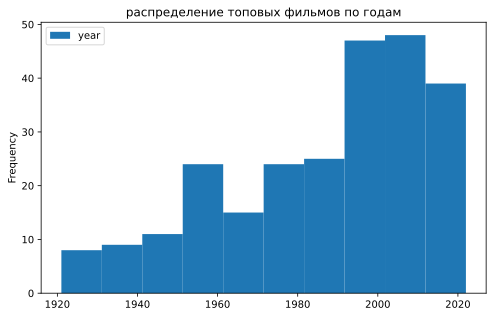

In [86]:
#dtype of column 'year' is object
#changing dtype to numeric to make a plot

data["year"] = data["year"].astype(float)
data.plot.hist(x = "movies", y = "year", title='распределение топовых фильмов по годам')

In [87]:
#task_5. Построить распределение топовых фильмов по рейтингу (округлить до сотых, десятых, целых и отрисовать)
data.ratings.describe()

count                   250
unique                  250
top       8.596258983097895
freq                      1
Name: ratings, dtype: object

In [88]:
#changing dtype to numeric to make a plot
data["ratings"] = pd.to_numeric(data["ratings"])

<AxesSubplot:title={'center':'распределение топовых фильмов по рейтингу (округление до сотых)'}, ylabel='Frequency'>

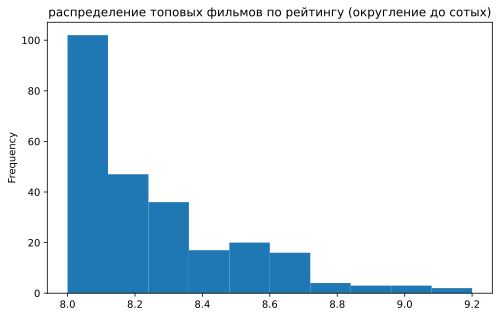

In [89]:
d2 = data["ratings"].round(decimals=1)

d2.plot.hist(x = "movies", y = "ratings", title='распределение топовых фильмов по рейтингу (округление до сотых)')

<AxesSubplot:title={'center':'распределение топовых фильмов по рейтингу (округление до десятых)'}, ylabel='Frequency'>

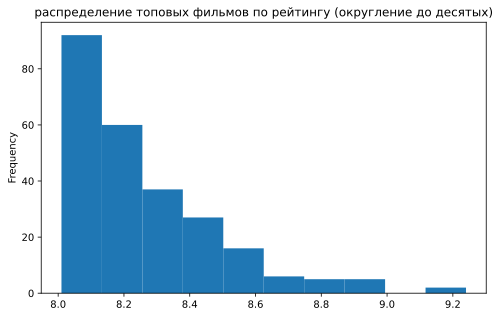

In [90]:
d1 = data["ratings"].round(decimals=2)

d1.plot.hist(x = "movies", y = "ratings", title='распределение топовых фильмов по рейтингу (округление до десятых)')

<AxesSubplot:title={'center':'распределение топовых фильмов по рейтингу (округление до целых)'}, ylabel='Frequency'>

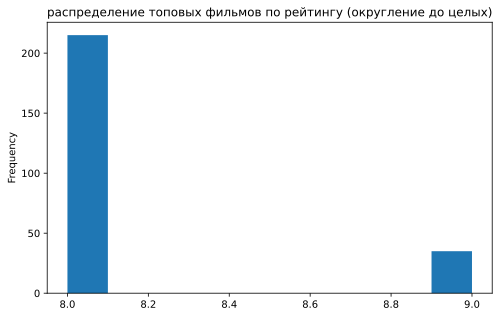

In [91]:
d0 = data["ratings"].round(decimals=0)

d0.plot.hist(x = "movies", y = "ratings", title='распределение топовых фильмов по рейтингу (округление до целых)')

In [92]:
#task_6. Используйте ссылку http://www.imdb.com/ и динамически добавляя ссылку на фильм из колонки links соберите описание фильмов.
#Добавьте эту информацию в исходный датафрейм.

#making a list of full urls
links_list = data["links"].tolist()
imdb = "http://www.imdb.com"
full_links_list = [imdb + x for x in links_list]

In [93]:
description_list = []

In [94]:
def get_description(link):
    html_text = requests.get(link).text
    soup = BeautifulSoup(html_text, 'lxml')
    return soup.find_all(attrs={"name": "description"})[0].get("content")

In [95]:
for i in full_links_list:
    description_list.append(get_description(i))

In [96]:
#adding new column to df
data["description"] = description_list
data.head()

,movies,ratings,crew,links,title,year,genre,description
0,"[\n 1.\n , [Побег из Шоушенка], \n, ...",9.240019,"Frank Darabont (dir.), Tim Robbins, Morgan Fre...",/title/tt0111161/,Побег из Шоушенка,1994.0,[Drama],Побег из Шоушенка: Directed by Frank Darabont....
1,"[\n 2.\n , [Крёстный отец], \n, [(19...",9.161081,"Francis Ford Coppola (dir.), Marlon Brando, Al...",/title/tt0068646/,Крёстный отец,1972.0,"[Crime, Drama]",Крёстный отец: Directed by Francis Ford Coppol...
2,"[\n 3.\n , [Темный рыцарь], \n, [(20...",8.994030,"Christopher Nolan (dir.), Christian Bale, Heat...",/title/tt0468569/,Темный рыцарь,2008.0,"[Action, Crime, Drama]",Темный рыцарь: Directed by Christopher Nolan. ...
3,"[\n 4.\n , [Крёстный отец 2], \n, [(...",8.990209,"Francis Ford Coppola (dir.), Al Pacino, Robert...",/title/tt0071562/,Крёстный отец 2,1974.0,"[Crime, Drama]",Крёстный отец 2: Directed by Francis Ford Copp...
4,"[\n 5.\n , [12 рaзгневанных мужчин],...",8.950843,"Sidney Lumet (dir.), Henry Fonda, Lee J. Cobb",/title/tt0050083/,12 рaзгневанных мужчин,1957.0,"[Crime, Drama]",12 рaзгневанных мужчин: Directed by Sidney Lum...


In [97]:
#task_7. С помощью регулярных выражений найдите в текстах описания фильмов имена актеров, если это возможно.
#Добавьте эту информацию в датафрейм и посчитайте, для скольких фильмов получилось это сделать.

actors = re.findall(r'(?<=With )[^.]+', str(description_list))

In [101]:
#additional check
actors_list = [x for x in actors if len(x) > 2  and len(x) < 123]

In [102]:
data["actors"] = actors_list
data.head()

,movies,ratings,crew,links,title,year,genre,description,actors
0,"[\n 1.\n , [Побег из Шоушенка], \n, ...",9.240019,"Frank Darabont (dir.), Tim Robbins, Morgan Fre...",/title/tt0111161/,Побег из Шоушенка,1994.0,[Drama],Побег из Шоушенка: Directed by Frank Darabont....,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi..."
1,"[\n 2.\n , [Крёстный отец], \n, [(19...",9.161081,"Francis Ford Coppola (dir.), Marlon Brando, Al...",/title/tt0068646/,Крёстный отец,1972.0,"[Crime, Drama]",Крёстный отец: Directed by Francis Ford Coppol...,"Marlon Brando, Al Pacino, James Caan, Richard S"
2,"[\n 3.\n , [Темный рыцарь], \n, [(20...",8.994030,"Christopher Nolan (dir.), Christian Bale, Heat...",/title/tt0468569/,Темный рыцарь,2008.0,"[Action, Crime, Drama]",Темный рыцарь: Directed by Christopher Nolan. ...,"Christian Bale, Heath Ledger, Aaron Eckhart, M..."
3,"[\n 4.\n , [Крёстный отец 2], \n, [(...",8.990209,"Francis Ford Coppola (dir.), Al Pacino, Robert...",/title/tt0071562/,Крёстный отец 2,1974.0,"[Crime, Drama]",Крёстный отец 2: Directed by Francis Ford Copp...,"Al Pacino, Robert Duvall, Diane Keaton, Robert..."
4,"[\n 5.\n , [12 рaзгневанных мужчин],...",8.950843,"Sidney Lumet (dir.), Henry Fonda, Lee J. Cobb",/title/tt0050083/,12 рaзгневанных мужчин,1957.0,"[Crime, Drama]",12 рaзгневанных мужчин: Directed by Sidney Lum...,"Martin Balsam, John Fiedler, Lee J"


In [ ]:
#task_8. Распарсите исходную страницу с топ-250 фильмов и получите для каждого фильмов количество оценок.
#Найдите 10 фильмов (вывести их название и кол-во оценок), у которых самое большое количество оценок.

In [103]:
#url scraping
user_ratings_list = []
user_ratings_strings = soup.find_all(attrs={'class': 'ratingColumn imdbRating'})
for u in user_ratings_strings:
  a = u.strong["title"]
  #selecting user ratings number from a string
  idx_start = a.find("based on ") + len("based on ")
  idx_end = a.find(" user ratings")
  a = a[idx_start:idx_end]
  user_ratings_list.append(a)

In [104]:
#adding user ratings into copied df to get top-10
data_with_user_rating = data.copy()
data_with_user_rating["user_ratings"] = user_ratings_list

In [105]:
data_with_user_rating['user_ratings'].describe()

count         250
unique        250
top       456,258
freq            1
Name: user_ratings, dtype: object

In [106]:
#dtype of user_ratings is object, can't rank
#changing type of data to integer
data_with_user_rating['user_ratings'] = data_with_user_rating['user_ratings'].str.replace(',', '').astype(int)

In [107]:
data_with_user_rating.head()

,movies,ratings,crew,links,title,year,genre,description,actors,user_ratings
0,"[\n 1.\n , [Побег из Шоушенка], \n, ...",9.240019,"Frank Darabont (dir.), Tim Robbins, Morgan Fre...",/title/tt0111161/,Побег из Шоушенка,1994.0,[Drama],Побег из Шоушенка: Directed by Frank Darabont....,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",2565165
1,"[\n 2.\n , [Крёстный отец], \n, [(19...",9.161081,"Francis Ford Coppola (dir.), Marlon Brando, Al...",/title/tt0068646/,Крёстный отец,1972.0,"[Crime, Drama]",Крёстный отец: Directed by Francis Ford Coppol...,"Marlon Brando, Al Pacino, James Caan, Richard S",1765546
2,"[\n 3.\n , [Темный рыцарь], \n, [(20...",8.994030,"Christopher Nolan (dir.), Christian Bale, Heat...",/title/tt0468569/,Темный рыцарь,2008.0,"[Action, Crime, Drama]",Темный рыцарь: Directed by Christopher Nolan. ...,"Christian Bale, Heath Ledger, Aaron Eckhart, M...",2527987
3,"[\n 4.\n , [Крёстный отец 2], \n, [(...",8.990209,"Francis Ford Coppola (dir.), Al Pacino, Robert...",/title/tt0071562/,Крёстный отец 2,1974.0,"[Crime, Drama]",Крёстный отец 2: Directed by Francis Ford Copp...,"Al Pacino, Robert Duvall, Diane Keaton, Robert...",1222023
4,"[\n 5.\n , [12 рaзгневанных мужчин],...",8.950843,"Sidney Lumet (dir.), Henry Fonda, Lee J. Cobb",/title/tt0050083/,12 рaзгневанных мужчин,1957.0,"[Crime, Drama]",12 рaзгневанных мужчин: Directed by Sidney Lum...,"Martin Balsam, John Fiedler, Lee J",757647


In [108]:
#getting top-10
data_with_user_rating = data_with_user_rating.nlargest(10, "user_ratings")
print(data_with_user_rating[["title", "user_ratings"]])

                                  title  user_ratings
0                     Побег из Шоушенка       2565165
2                         Темный рыцарь       2527987
12                               Начало       2251463
11                      Бойцовский клуб       2018452
10                         Форрест Гамп       1978693
7                    Криминальное чтиво       1969516
15                              Матрица       1846923
8      Властелин колец: Братство кольца       1787025
1                         Крёстный отец       1765546
6   Властелин колец: Возвращение короля       1765275


In [109]:
#task_9. Постройте топ 10 слов, которые встречаются 1) в названии фильмов, 2) в описании фильмов, 3) в названии и в описании фильмов
title_list = data["title"].to_list()

In [110]:
title_description_list = title_list + description_list

In [111]:
def top_10_words (list):
  tokenized = ' '.join(list).lower().split()
  counter = Counter (tokenized)
  most_occur = counter.most_common(10)
  return most_occur

In [112]:
top_10_words(title_list)

[('в', 11),
 ('и', 9),
 ('на', 8),
 ('отец', 4),
 ('по', 4),
 ('властелин', 3),
 ('колец:', 3),
 ('звёздные', 3),
 ('войны.', 3),
 ('эпизод', 3)]

In [114]:
top_10_words(description_list)

[('a', 388),
 ('the', 362),
 ('with', 312),
 ('by', 294),
 ('directed', 250),
 ('to', 234),
 ('of', 205),
 ('and', 175),
 ('in', 150),
 ('his', 146)]

In [115]:
top_10_words(title_description_list)

[('a', 389),
 ('the', 365),
 ('with', 312),
 ('by', 294),
 ('directed', 250),
 ('to', 237),
 ('of', 206),
 ('and', 175),
 ('in', 150),
 ('his', 146)]

In [ ]:
#due to my IP address titles are in Russian, descriptions are in English

In [ ]:
#task_10. Спарсить теги фильмов со страницы каждого фильма.

In [116]:
genre_list = []

In [117]:
def get_genres(page_url):
  genres = []
  response = requests.get(page_url)
  t_soup = BeautifulSoup(response.text, 'lxml')
  for td in t_soup.find(attrs={"class": "ipc-chip-list sc-16ede01-4 bMBIRz"}).parent.find_all(attrs={"class": "ipc-chip__text"}):
    genres.append(td.text)
  return genres

In [118]:
genre_list = []
for i in full_links_list:
    try:
      genre_list.append(get_genres(i))
    except:
      genre_list.append([])

In [119]:
data["genre"] = genre_list
data.head()

,movies,ratings,crew,links,title,year,genre,description,actors
0,"[\n 1.\n , [Побег из Шоушенка], \n, ...",9.240019,"Frank Darabont (dir.), Tim Robbins, Morgan Fre...",/title/tt0111161/,Побег из Шоушенка,1994.0,[Drama],Побег из Шоушенка: Directed by Frank Darabont....,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi..."
1,"[\n 2.\n , [Крёстный отец], \n, [(19...",9.161081,"Francis Ford Coppola (dir.), Marlon Brando, Al...",/title/tt0068646/,Крёстный отец,1972.0,"[Crime, Drama]",Крёстный отец: Directed by Francis Ford Coppol...,"Marlon Brando, Al Pacino, James Caan, Richard S"
2,"[\n 3.\n , [Темный рыцарь], \n, [(20...",8.994030,"Christopher Nolan (dir.), Christian Bale, Heat...",/title/tt0468569/,Темный рыцарь,2008.0,"[Action, Crime, Drama]",Темный рыцарь: Directed by Christopher Nolan. ...,"Christian Bale, Heath Ledger, Aaron Eckhart, M..."
3,"[\n 4.\n , [Крёстный отец 2], \n, [(...",8.990209,"Francis Ford Coppola (dir.), Al Pacino, Robert...",/title/tt0071562/,Крёстный отец 2,1974.0,"[Crime, Drama]",Крёстный отец 2: Directed by Francis Ford Copp...,"Al Pacino, Robert Duvall, Diane Keaton, Robert..."
4,"[\n 5.\n , [12 рaзгневанных мужчин],...",8.950843,"Sidney Lumet (dir.), Henry Fonda, Lee J. Cobb",/title/tt0050083/,12 рaзгневанных мужчин,1957.0,"[Crime, Drama]",12 рaзгневанных мужчин: Directed by Sidney Lum...,"Martin Balsam, John Fiedler, Lee J"


Задача 1.
Получить список всех участников команд (убрать постфикс `(dir.)` у директоров). Найти количество уникальных имен. 

Задача 2.
Получить список всех директоров. Построить распределение (визуализация обязательна) и найти директора(ов), у которого(ых) больше всего фильмов в топе.

Задача 3. Найти участника(ов) команд, у которого(ых) больше всего фильмов в топе.

Задача 4. Построить распределение топовых фильмов по годам

Задача 5. Построить распределение топовых фильмов по рейтингу:


*   Округлить до сотых и отрисовать
*   Округлить до десятых и отрисовать
*   Округлить до целых и отрисовать

Задача 6. Используйте ссылку `http://www.imdb.com/` и динамически добавляя ссылку на фильм из колонки `links` соберите описание фильмов. Пример поиска необходимого текст представлен ниже. Добавьте эту информацию в исходный датафрейм.











Задача 7. С помощью регулярных выражений найдите в текстах описания фильмов имена актеров, если это возможно (то есть - они там упоминаются). Добавьте эту информацию в датафрейм и посчитайте, для скольких фильмов получилось это сдлеать. Подсказка: перечисление актеров иногда начинается с with. 


Задача 8. Распарсите исходную страницу с топ-250 фильмов и получите для каждого фильмов количество оценок. Пример текста в исходной странице:`9.2 based on 2,554,919 user ratings`. Из этого текста нужно достать = `2,554,919`. Подсказка: используя метод `find_all` с аргументом `attrs` в который нужно передать `{'class': 'ratingColumn imdbRating'}` от страници `http://www.imdb.com/chart/top`. Найдите 10 фильмов (вывести их название и кол-во оценок) у которых, самое большое количество оценок.


Задача 9. Постройте топ 10 слов, которые встречаются 

1.   в названии фильмов
2.   в описании фильмов
3.   в названии и в описании фильмов


Задача 10*. Спарсить теги фильмов со страницы каждого фильма, так например для `The Godfather` ожидается получить список из `Crime, Drama`. (Можно увидеть эти теги по картинкой к фильму)
